# Matrix Factorization for Collaborative Filtering

For a streaming platform like Netflix, Amazon or Disney+, being able to accurately recommend shows or movies to its users is a key feature necessary to keep clients engaged with the platform's content and therefore subscribed. The difference with many other machine learning problems is that we rarely have much information about an user's preferences apart from the movies or shows he has interacted with.

It turns out, the interactions user-content may be enough to create an effective recommender system thanks to the elegant solution of matrix factorization. Before diving into the method, let's introduce our data.

## MovieLens Dataset

MovieLens is a non-commercial recommender run by the research group GroupLens at the University of Minnesota. We will use a small dataset containing 100k ratings of different users. Each user has given a movie a score from 1 to 5 stars.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
movies = pd.read_csv("data/movies.csv")
ratings = pd.read_csv("data/ratings.csv")

In [3]:
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [4]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


We are interested in these 2 files. The ratings dataframe contains an instance of user-movie interaction, and the movies dataframe keeps track of the movieId and title along with some genre labels.

Let's start by exploring the data and making sure there is no missing data or outliers.

In [5]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Min and Max rating values are as expected, and there are no missing values in the ratings dataframe.

In [7]:
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


We can see there is a small problem now; the max movieId in the movies dataframe is 193609, but there are only 9742 movies in this dataframe! This is because we are dealing with a reduced dataset where some movies are not included. There may be missing userId values too, so we will reencode them too.

We will create a function to perform the necessary transformations:

- Drop timestamp and genres columns
- Reencode movieId and userId 

We will also create a dictionary to keep track of the movie titles and their new movieId. This function will output our data as a numpy array.
    

In [9]:
def mf_prep(ratings, movies):
    
    # Let's drop the timestamp and genre columns as the will be of no use to us
    ratings.drop('timestamp',axis=1,inplace=True)
    movies.drop('genres',axis=1, inplace=True)
    
    # We will merge the dataframes so that we can easily keep title and movieId correspondence
    merged_df = ratings.merge(movies, how='left', on='movieId')
    
    # Pandas has an easy way of reencoding our userId and movieId
    merged_df.userId = merged_df.userId.astype('category').cat.codes.values
    merged_df.movieId = merged_df.movieId.astype('category').cat.codes.values
    
    # Now we create a movie dictionary where each key is the movieId and the value its title as a string
    movie_dict = merged_df.groupby(['movieId']).max().drop(['userId','rating'],axis=1).to_dict()
    
    # It will be convienient to output our data as a numpy array
    X = np.array([merged_df['userId'], merged_df['movieId']]).T
    Y = np.array(merged_df['rating'])
    
    return X, Y, movie_dict['title']

    

In [10]:
X, Y, movie_dict = mf_prep(ratings,movies)

## Item-Based Recommender - Matrix Factorization

The idea behind Matrix Factorization starts with creating an utility matrix R where each row is an user instance and each column a movie

In [11]:
R = pd.pivot_table(data=ratings,values='rating',index='userId', columns='movieId')
R

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are a lot of missing values, which is to be expected! As most users will not have rated most movies, the matrix will always be quite sparse.

What we will try to achieve by factorizing this matrix is obtaining two matrices U and M whose matrix product will result in the utility matrix R. The matrix U will have $n$ rows being the number of users and $k$ columns which will be a parameter of our choosing. The M matrix on the other hand will have $m$ rows representing each unique movie and $k$ columns. So that if we perform the factorization correctly  $U M^{T} = R$

What is really interesting about this is the $k$ parameter. First it will determine the dimension of the matrix along one of its axis, so it can be a tool to reduce the dimension of $R$ if that is what we are after. On the other hand, a bigger $k$ will make it easier for the matrix productto be a good approximation of $R$.

If we denote the k columns for a certain user in the U matrix as $x_{1},...,x_{k}$ and the same columns for a certain movie in the M matrix as $\theta_{1},...,\theta_{k}$, the calculation during the matrix product for that user-movie interaction in the R matrix will be
\begin{equation}
x_{1} \theta_{1} + ... + x_{k} \theta_{k}
\end{equation}

These $k$ columns can be interpreted as features determining wether an user will like or not a certain movie. The $x$ features denote an user taste for certain "movie characteristics", and the $theta$ a representation of how much of these characteristics a certain movie has. $k$ becomes a dimensionality of taste!, and it will be an important hyperparameter to tune and study.

However, creating the matrix $R$ explicitly takes a lot of computing power and great amounts of RAM memory (We could only do it because we are dealing with a small dataset). One of the advantages of matrix factorization is to reduce. One of the advantages of using Stochastic Gradient Descent is that we will perform our calculations for each user-rating pair, therefore calculating this matrix will not be necessary.

Before we proceed, we need to be smart about how we split the dataset. Every user and movie we have available should be present in the training set. In order to do this we will make make a stratify split by user, and then make sure every movie is in the training set moving them from the test set (and deleting them).

In [12]:
def mf_split(X,y, test_size=0.22):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size, stratify=X[:,0])
    
    movie_train_index = X_train[:,1]
    movie_test_index = X_test[:,1]
    deleted_index = []

    for index,element in enumerate(movie_test_index):
        if element not in movie_train_index:
            X_train = np.concatenate((X_train,X_test[index,:].reshape((1,2))),axis=0)        
            y_train = np.append(y_train,y_test[index])
            deleted_index.append(index)

    X_test = np.delete(X_test,deleted_index,axis=0)
    y_test = np.delete(y_test,deleted_index)
    
    return X_train, X_test, y_train, y_test
    

In [13]:
X_train, X_test, y_train, y_test = mf_split(X,Y, test_size = 0.22)

And where is the validation set? Given that we have access to bigger non-reduced datasets by the movieLens group, we can use our "test set" as what would traditionally be a validation set, and test our model at the end in a different and bigger dataset if we wish to do so.

## FunkSGD

Our implementation will be based on the proposed model by Simon Funk for the famous competition held by Netflix. For starters, we will define our rating not only as the result of the matrix product of U and M, but with the addition of some bias terms

\begin{equation}
r_{um}^{pred} = \mu + b_{u} + b_{m} + U_{u} M_{m}^{T}
\end{equation}

With $\mu$ the average ratings of all movies, $b_{u}$ an user bias and $b_{m}$ a movie bias.
This way, our matrix factorization algorithm actually models small variations from the average global rating, added by variations intrinsic in each user and moÇvie.

This is a common and proven model which gives better results than trying to rely completely on the result of matrix factorization.

The proposed loss function by Simon Funk was

\begin{equation}
L = \sum_{u,m} ( r_{um} - r_{um}^{pred})^{2} + \lambda \sum_{u} \lvert {b_{u}} \rvert^{2} + \lambda \sum_{u} \lvert {b_{m}} \rvert^{2} + \lambda \sum_{u} \lvert {U_{u}} \rvert^{2} + + \lambda \sum_{u} \lvert {M_{m}} \rvert^{2}
\end{equation}

With $\lambda$ a regularization parameter. It is possible to choose a differente lambda for each term in the right handside of the equation but for simplicity, we will use just one.

Along with the Gradient Descent update terms we will be ready to create our model

\begin{equation}
b_{u} \leftarrow b_{u} + \eta (e_{um} - \lambda b_{u})
\end{equation}
\begin{equation}
b_{m} \leftarrow b_{m} + \eta (e_{um} - \lambda b_{m})
\end{equation}
\begin{equation}
U_{u} \leftarrow U_{u} + \eta (e_{um}M_{m} - \lambda U_{u})
\end{equation}
\begin{equation}
M_{m} \leftarrow M_{m} + \eta (e_{um}U_{u} - \lambda M_{m})
\end{equation}

Where $e_{um}=r_{um} - r_{um}^{pred}$ is the error in our prediction.

## Creating our model

A few things we will include in our model that we haven't mentioned previously are:
- A popularity recommender for brand new users 
- A few methods to add users, calculate RMSE and output recommendations

Also, we will not optimize the mentioned loss functioned but the RMSE, it will also be our metric of choice to measure our model for easier comparison with other models we can find in different papers.

Note that RMSE is not an optimal accuracy metric for recommender systems, other more compelx metrics may be better suited for this task, but we will follow through for the sake of easier comparison.

In [14]:
class MFsgd():
    def __init__(self, latent_features = 25, n_epoch = 30, learning_rate = 0.001,
                 regularization = 0.001, random_state = None,verbose=False):
        
        # Here we initialize relevant parameters our model has to keep track of
        
        self.k = latent_features # number of latent features
        self.n_epoch = n_epoch # number of epochs for training
        self.learning_rate = learning_rate ## learning rate parameter
        self.reg = regularization # regularization parameter
        self.random_state = random_state # random state in random initialization
        self.present_epoch = 0 # present epoch in training
        self.verbose = verbose # parameter to indicate if we want progress feedback during training
        
        
        
    def init_params(self,X,Y):    
        
        np.random.seed(seed=self.random_state) 
        self.r = Y.shape[0] ## number of ratings
        self.n = np.unique(X_train[:,0]).shape[0] # number of unique users
        self.m = np.unique(X_train[:,1]).shape[0] # number of unique movies
        self.U = np.random.rand(self.n,self.k) # Initialize user and latent factor matrix
        self.M = np.random.rand(self.m,self.k) # Initialize user and latent factor matrix
        self.bu= np.random.rand(self.n) # Initialize user bias
        self.bm= np.random.rand(self.m) # Initialize movie bias
        self.mu = np.mean(Y) # Calculate global bias: global mean of ratings
        
    def load_movie_dict(self, movie_dict):
        self.movie_dict = movie_dict
    
    def movie_avg(self,X,Y):
        
        movie_avg_ratings = np.zeros((np.unique(X[:,1]).shape[0],3))
        
        for x in np.unique(X[:,1]):    
            movie_avg_ratings[x,0] = np.average(Y[np.where(X[:,1]==x)])
            movie_avg_ratings[x,1] = np.sum(X[:,1] == x)
            movie_avg_ratings[x,2] = x
            
        self.movie_avg_ratings = movie_avg_ratings
        
    
    def popularity_recommender(self,min_score=4, min_ratings=20):
        
        user_movie_ratings = self.movie_avg_ratings        
                  
        recommender_list = user_movie_ratings[user_movie_ratings[:,0] > min_score]
        user_movie_ratings = user_movie_ratings[user_movie_ratings[:,1] > min_ratings]
        user_movie_ratings = user_movie_ratings[user_movie_ratings[:,1].argsort()]
        user_movie_ratings = np.flip(user_movie_ratings,axis=0)
        
        list1 = list(np.random.choice(user_movie_ratings[:10,2], size=5,replace=False))
        list2 = list(np.random.choice(user_movie_ratings[10:30,2], size=5,replace=False))
        final_list= []
        final_list = list1 + list2
        
        
        print_list = []
        
        for movie in final_list:
            print_list.append(self.movie_dict[movie])
            
        return print_list
    
    
    
    def predict_rating(self,user,movie):
        
                 
        return self.mu + self.bu[user]+self.bm[movie] + np.dot(self.U[user],self.M[movie])
    
    
    def transform(self,X):
        
        # Returns the whole predicted ratings vector
        
        size = X[:,0].shape[0]
        y_hat = np.empty([size])
        for elem in range(size):
            user = X[elem,0]
            movie = X[elem,1]
            y_hat[elem] = self.predict_rating(user,movie)
        return y_hat
    
    def calc_error(self,X,Y):
        
        # Calculates RMSE for the given data
                
        size = X[:,0].shape[0]
        se = np.sum(np.square(Y - self.transform(X)))
        mse = se/size
        rmse = np.sqrt(mse)
        return rmse
    
    def single_sgd_step(self,X,Y,index=0):
        
        ## Stochastic Gradient Descent ##
        
        # First declaring user and movie
        if X.ndim == 2:
            user = X[index,0]
            movie = X[index,1]
        else:
            user = X[0]
            movie = X[1]
        lr = self.learning_rate
        l = self.reg
            
        # With the help of the previously defined predict_rating function
        # we calculate the error between our prediction and the training labels
            
        prediction = self.predict_rating(user,movie)
        err = Y[index] - prediction ## 
            
        # We update the model parameters accordingly
            
        self.U[user] += lr*(err*self.M[movie]-l*self.U[user])
        self.M[movie] += lr*(err*self.U[user]-l*self.M[movie])
        self.bu[user] += lr*(err - l*self.bu[user])
        self.bm[movie] += lr*(err - l*self.bm[movie])
    
    def sgd_step(self,X,Y):
        
        # This function performs SGD once for every user rating pair in the dataset       
        
        for elem in range(self.r):        
                        
            self.single_sgd_step(X,Y,elem)
            
            
    def fit(self,X,Y):
        
        
        self.init_params(X,Y)
        self.movie_avg(X,Y)
        for epoch in range(self.n_epoch):
            self.present_epoch += 1
            if self.verbose:
                print('Training epoch... ({}/{})'.format(self.present_epoch,self.n_epoch))
            self.sgd_step(X,Y)
            
    def add_user_rating(self,X=None,Y=None,n_epoch=5):
        
        if (X is None) and (Y is None):
            new_user = np.zeros((1,self.k))
            self.U = np.concatenate((self.U,new_user), axis=0)
            
        elif (X is not None) and (Y is not None):
            user = X[0]
            movie = X[1]
            rating = Y
            if user >= self.U.shape[0]:
                self.U = np.concatenate((self.U, np.random.rand(1,self.k)),axis=0)
                for epoch in range(n_epoch):
                    self.single_sgd_step(X,Y)
            else:
                if np.sum(self.U[user] == 0) == self.k:
                    
                    self.U[user] = np.random.rand(1,self.k)                    
                    for epoch in range(n_epoch):
                        self.single_sgd_step(X,Y)
                else:
                    for epoch in range(n_epoch):
                        self.single_sgd_step(X,Y)
                
            
            
            
    def recommend(self,user):
        if np.sum(self.U[user] == 0) == self.k:
            
            return self.popularity_recommender()
            
        
        else:
            
            user_ratings = self.mu + self.bu[user]+ (self.bm + self.U[user] @ (self.M).T)
            
            movie_ratings = np.copy(self.movie_avg_ratings)
            movie_ratings[:,0] = user_ratings
            movie_ratings = movie_ratings[movie_ratings[:,0].argsort()]
            movie_ratings = np.flip(movie_ratings,axis=0)
            movie_list = list(movie_ratings[:10,2])
            print_list= []
            
            for movie in movie_list:
                print_list.append(self.movie_dict[movie])
            return print_list
    
            

Let's train our model for about 10 epochs with some arbitrary hyperparameters, just to check if it works as expected

In [21]:
mf = MFsgd(random_state=42,n_epoch=10, latent_features=30, learning_rate = 0.001, regularization=0.001, verbose=True)
mf.fit(X_train,y_train)
mf.calc_error(X_test,y_test)

Training epoch... (1/10)
Training epoch... (2/10)
Training epoch... (3/10)
Training epoch... (4/10)
Training epoch... (5/10)
Training epoch... (6/10)
Training epoch... (7/10)
Training epoch... (8/10)
Training epoch... (9/10)
Training epoch... (10/10)


1.1398670822440224

We get an RMSE of almost 1.14 which is pretty bad, but to be expected as we just trainied for 10 epochs with some arbitrary paramaters. Next thing we will do is run it over a considerable amount of time to determine the right amount of epochs, and take that as a standard in further tuning

In [22]:
n_epoch=150
mf = MFsgd(learning_rate=0.001, verbose=True, random_state=42,latent_features=30, regularization = 0.001)
mf.init_params(X_train,y_train)
training_error = []
val_error = []
for epoch in range(n_epoch):
    mf.sgd_step(X_train,y_train)
    training_error.append(mf.calc_error(X_train, y_train))
    val_error.append(mf.calc_error(X_test, y_test))

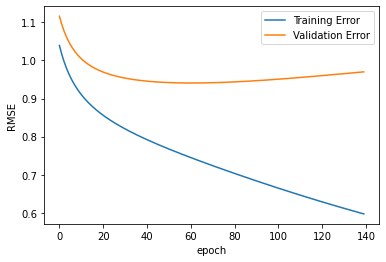

In [23]:
plt.plot(training_error[10:],label='Training Error')
plt.plot(val_error[10:], label='Validation Error')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [26]:
print(np.argmin(val_error))
print(np.min(val_error))

70
0.9406538783401853


Despite the training error continuously decreasing, the validation error reaches a minimun at 70 epochs and then begins to climb again due to overfitting. We will train our final model for around 70 epochs for the best results.

## Searching for the best parameters

The next sensible step is to find a good combination of hyperparameters to further increase the model accuracy. We will perform a grid search for the learning rate, regularization and number of latent features. Due to the time it will take to perform this search for a reasonable number of combinations, we will limit our hyperparameters a lot and train each model for just 30 epochs

In [28]:
learning_rate = [0.01,0.001]
regularization = [0.1, 0.01]
latent_features = [20,30,40]
n_epoch= 30
for lr in learning_rate:
    for l in regularization:
        for k in latent_features:
            mf = MFsgd(random_state=42,latent_features=k,n_epoch=n_epoch, regularization=l, learning_rate=lr)
            mf.fit(X_train,y_train)
            rmse = mf.calc_error(X_test,y_test)
            print('learning_rate: {} | regularization: {} | latent_features_ {} | val_rmse: {}'.format(lr,l,k,rmse))

learning_rate: 0.01 | regularization: 0.1 | latent_features_ 20 | val_rmse: 0.8604880533106013
learning_rate: 0.01 | regularization: 0.1 | latent_features_ 30 | val_rmse: 0.8621845151737066
learning_rate: 0.01 | regularization: 0.1 | latent_features_ 40 | val_rmse: 0.8653065733519538
learning_rate: 0.01 | regularization: 0.01 | latent_features_ 20 | val_rmse: 0.9724544488444891
learning_rate: 0.01 | regularization: 0.01 | latent_features_ 30 | val_rmse: 1.000693891760308
learning_rate: 0.01 | regularization: 0.01 | latent_features_ 40 | val_rmse: 1.0279277655205838
learning_rate: 0.001 | regularization: 0.1 | latent_features_ 20 | val_rmse: 0.9245865229836965
learning_rate: 0.001 | regularization: 0.1 | latent_features_ 30 | val_rmse: 0.9363701248010097
learning_rate: 0.001 | regularization: 0.1 | latent_features_ 40 | val_rmse: 0.9470585925202062
learning_rate: 0.001 | regularization: 0.01 | latent_features_ 20 | val_rmse: 0.9454082332198909
learning_rate: 0.001 | regularization: 0.01

There are quite a few relevant conclusions that can be drawn from the grid search:

1. It seems our previous learning rate of 0.001 led us to get stuck in a local minimum, so a bigger value like 0.01 or even a proper learning rate schedule could greatly improve performance.

2. A higher regularization parameter also seems to be beneficial as it probably reduces overfitting problems

3. The number of latent features doesn't seem very impactful at least in the considered range, however we can see k=40 generally underperforms all else being equal. So a lower value like 20 or 30 will be faster to compute without a great loss in performance


Our best hyperparameters seem to be learning_rate=0.01, regularization=0.1 and latent_features=20. It would be interesting to see if a training rate schedule could improve performance further.

We are gonna try a very simple one. It will start at 0.01 and will linearly decrease to 0.001 in a span of 75 epochs.

In [30]:
def lr_schedule(n,lr_start,lr_end,span):
    c0=lr_start
    c1=(lr_end-lr_start)/span
    return c0 + (c1*n)

Let's see how it performs

In [31]:
lr_start = 0.01
lr_end = 0.001

n_epoch=75
mf = MFsgd(random_state=42,latent_features=20,regularization=0.1)
mf.init_params(X_train,y_train)
training_error = []
val_error = []
for epoch in range(n_epoch):
    mf.learning_rate = lr_schedule(epoch,lr_start,lr_end,n_epoch)
    mf.sgd_step(X_train,y_train)
    training_error.append(mf.calc_error(X_train, y_train))
    val_error.append(mf.calc_error(X_test, y_test))

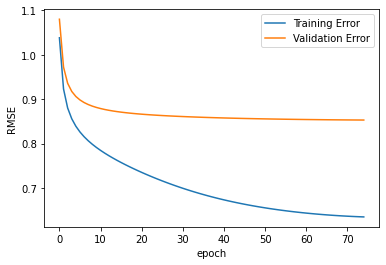

In [34]:
plt.plot(training_error,label='Training Error')
plt.plot(val_error, label='Validation Error')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [35]:
print(np.argmin(val_error))
print(np.min(val_error))

74
0.8530108720146229


IF we compare with the model using the found parameters and no learning rate schedule

In [36]:
mf =MFsgd(random_state=42,n_epoch=74, latent_features=20, learning_rate = 0.01, regularization=0.1)
mf.fit(X_train,y_train)

In [38]:
mf.calc_error(X_test,y_test)

0.8514929398451071

It seems our learning rate schedule actually worsened performance a bit. This is something that should change with some tweaking, but for now will drop the learning rate schedule.

## Delivering recommendations for existing and new users

One of the main drawbacks of collaborative filtering recommenders is the cold start problem. That is, what do we recommend an absolutely new user with no interactions?
In order to alleviate that we have included in our model a popularity recommeneder, recommending for a new user a set of high rated movies (with enough number of ratings). This is just one way to do it, and there are more complex models which take advantage of any other data you may have on the user or movies.

First we need to load the movie dictionary into our model, so that we can predict titles instead of movieIds

In [205]:
mf.load_movie_dict(movie_dict)

In order to get recommendations for a certain existing user, all we have to do is use the recommend method

In [230]:
recommendations = mf.recommend(100)

In [231]:
recommendations

['Belle époque (1992)',
 'Black Tar Heroin: The Dark End of the Street (2000)',
 'High and Low (Tengoku to jigoku) (1963)',
 'The Wait (2015)',
 'Faster (2010)',
 'Before Night Falls (2000)',
 'Come and See (Idi i smotri) (1985)',
 'Wristcutters: A Love Story (2006)',
 'Seve (2014)',
 "My Architect: A Son's Journey (2003)"]

Now in order to add a new user (with no previous data) all we have to do is use the add_user_rating method with no arguments

In [232]:
mf.add_user_rating()

The previous recommend method should detect there is no data on this user and automatically use the popularity recommender included

In [255]:
recommendations = mf.recommend(610)

In [256]:
recommendations

['Silence of the Lambs, The (1991)',
 'Forrest Gump (1994)',
 'Fight Club (1999)',
 'Matrix, The (1999)',
 'Shawshank Redemption, The (1994)',
 'Toy Story (1995)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Shrek (2001)',
 'True Lies (1994)',
 'Fugitive, The (1993)']

Well, those are some good recommendations! A new user won't be without masterpieces to watch